In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from scipy.stats import skew, kurtosis

torch.cuda.empty_cache()
# imports of custom blocks for model, data generation
from Ferret.ImplicitAm import ImplicitAmBre, ImplicitAmBer
from models import *
from create_plots import *
from utils import AmericanPutData, get_prices_put
from utils import S, T, K, RISK_FREE, SIGMA, S_MAX

## Put Option

### Content: 
1. **Generating Data**
2. **Training on Generated Data, Testing Both on Generated and Real Data**
3. **Training on Real Data, Testing on Real Data**
4. **Mixture of Data (70/30, 50/50), Testing on Real Data**


In [2]:
put_data = AmericanPutData(t_range=T, S_range=S, K=K, r=RISK_FREE, sigma=SIGMA)
# N_ivp - IVP points
# N_bvp - both BVP1 and BVP2 points
# N_col - colocation points
X = put_data.initialize_data(N_ivp=1000, N_bvp=3000, N_col=6000, is_call=False)
option = ImplicitAmBer(
    S[0],
    K,
    RISK_FREE,
    T[1],
    SIGMA,
    S_MAX,
    M=400,  # S
    N=365 * 3,  # t
    is_call=False,
)
option.price()
option_fde_prices = option.grid
data = get_prices_put(X, option_fde_prices, generated=True)
df = pd.DataFrame(
    data=data,
    columns=[
        "TimeToExp",
        "UnderlyingPrice",
        "TargetPrice",
        "OpenInterest",
        "Delta",
        "Gamma",
        "Theta",
        "Vega",
        "BSAprox",
    ],
)
df[["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]] = df[
    ["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]
].round(2)
df["OpenInterest"] = df["OpenInterest"].round(0)
df.to_csv("../train_data/generated_put.csv")

(10000, 8)


In [2]:
df = pd.read_csv("../train_data/generated_put.csv", index_col=0)
df.head()

,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,827.0,138.66,39.12,133.0,-0.876502,0.052474,-4.578248,15.334991,0.00
1,1045.0,113.58,45.38,228.0,-0.118852,0.002001,-7.851140,3.742773,6.48
2,395.0,194.28,27.86,937.0,-0.756109,0.000596,-1.044538,0.431675,0.00
3,563.0,112.40,45.66,109.0,-0.196355,0.012452,-4.211471,12.599267,7.64
4,980.0,145.38,37.53,72.0,-0.417402,0.012488,-0.112282,7.536177,0.00


Describe:
count    10000.000000
mean        38.778089
std         32.927976
min          0.000000
25%          0.000000
50%         37.310000
75%         55.310000
max        120.000000
Name: TargetPrice, dtype: float64

Skewness: 0.7879415236679352
Kurtosis: 0.4289552629526088


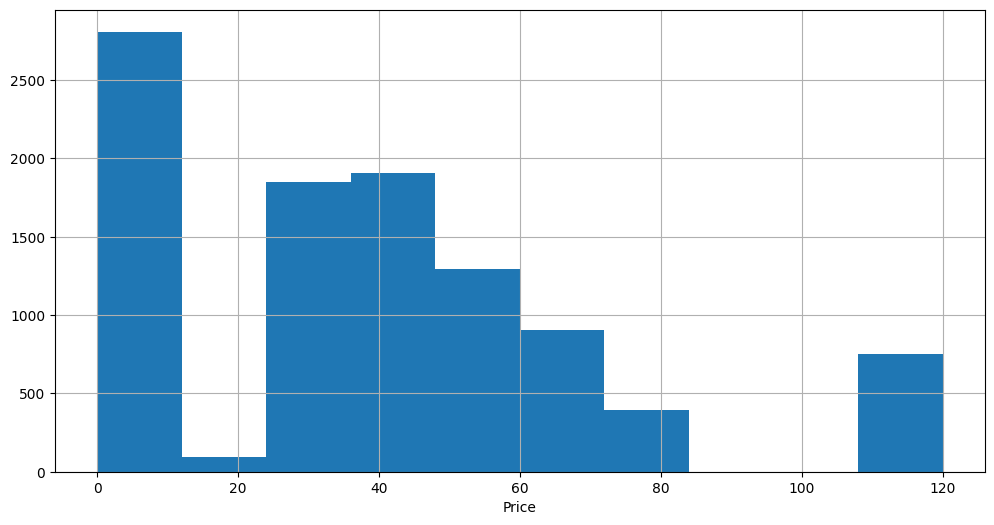

In [9]:
analyze_series(df.TargetPrice)

In [4]:
# Check for ITM and OTM
print(f"ITM count:{np.sum(df.UnderlyingPrice < K)}")
print(f"OTM count:{np.sum(df.UnderlyingPrice >= K)}")

ITM count:4272
OTM count:5728


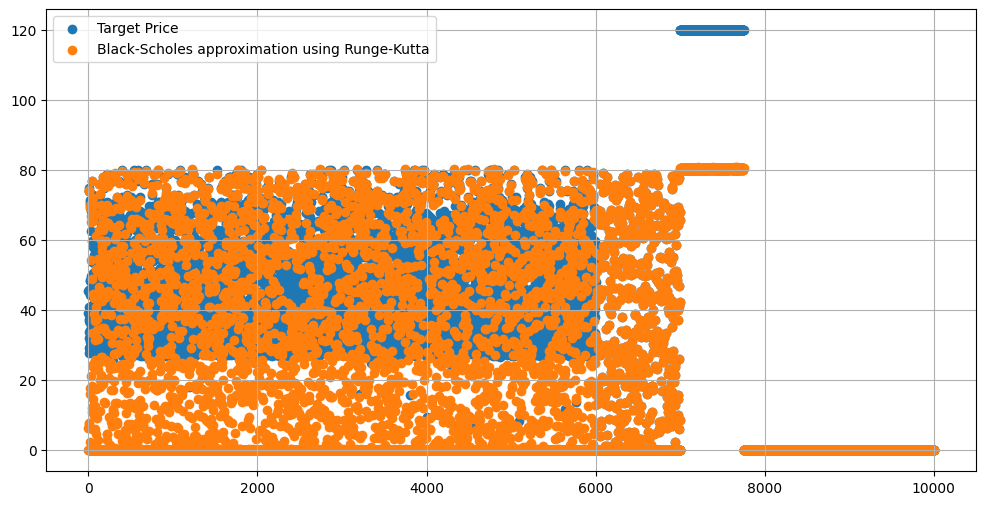

In [6]:
plt.figure(figsize=(12, 6))
plt.scatter(
    x=np.arange(1, len(df.TargetPrice) + 1, 1), y=df.TargetPrice, label="Target Price"
)
plt.scatter(x=np.arange(1, len(df.BSAprox) + 1, 1), y=df.BSAprox, label="Black-Scholes approximation using Runge-Kutta")
plt.legend()
plt.grid(True)
plt.show()

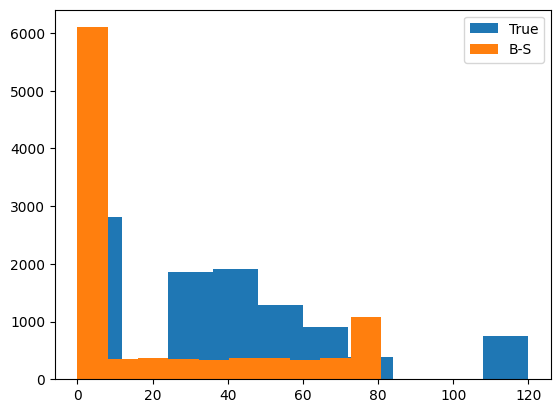

In [6]:
plt.hist(df.TargetPrice, label="True")
plt.hist(df.BSAprox, label="B-S")
plt.legend()
plt.show()

In [4]:
# # adding BSAprox column to real data
# # Run it once, only if u dont have saved df
# df_real = pd.read_csv("../train_data/put_df.csv", index_col=0)
# df_real = get_prices_put(df_real.to_numpy(), generated=False)
# df_real = pd.DataFrame(
#     data=df_real,
#     columns=[
#         [
#             "UnderlyingPrice",
#             "Type",
#             "Strike",
#             "OpenInterest",
#             "IV",
#             "Delta",
#             "Gamma",
#             "Theta",
#             "Vega",
#             "Time",
#             "TargetPrice",
#             "BSAprox",
#         ]
#     ],
# )
# df_real["BSAprox"] = df_real["BSAprox"].round(2)
# df_real.to_csv("../train_data/put_df_with_approx.csv")
# df_real.head()

In [7]:
df_real = pd.read_csv("../train_data/put_df_with_approx.csv", index_col=0)
df_real.head()

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
0,71.11,put,55.0,22,0.3314,-0.0004,0.0003,-0.0747,0.0253,21,0.02,0.0
1,71.11,put,60.0,118,0.3314,-0.0130,0.0060,-1.6451,0.5604,21,0.04,0.0
2,71.11,put,62.5,2026,0.3314,-0.0441,0.0168,-4.5773,1.5638,21,0.11,0.0
3,71.11,put,65.0,443,0.2918,-0.0873,0.0324,-6.8317,2.6647,21,0.20,0.0
4,71.11,put,67.5,165,0.2675,-0.1902,0.0605,-10.6215,4.5580,21,0.48,0.0


Describe:
count    223217.000000
mean          9.203034
std          20.484802
min           0.000000
25%           0.000000
50%           0.000000
75%          10.390000
max         600.720000
Name: BSAprox, dtype: float64

Skewness: 6.657008389112579
Kurtosis: 90.22743557230235


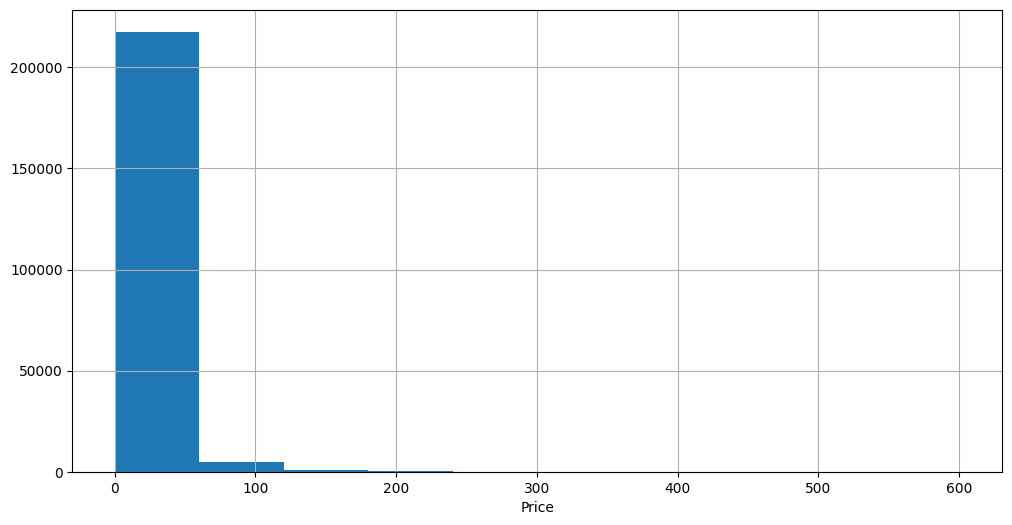

In [8]:
analyze_series(df_real.BSAprox)

In [3]:
# hyperparams for training
N_EPOCH = 20
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 5e-4
HIDDEN_LAYER = 20
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_put_8_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [4]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

cuda


In [6]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [7]:
# df = df_real.sample(n=20000, random_state=15)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_val.shape)

(8000, 9)
(2000, 9)


Describe:
count    16000.000000
mean         1.623540
std          6.854486
min       -600.230000
25%          0.120000
50%          0.550000
75%          1.980000
max         52.280000
dtype: float64

Skewness: -59.412366376729324
Kurtosis: 4889.175253597014
Describe:
count    4000.000000
mean        1.725048
std         3.616202
min        -9.390000
25%         0.110000
50%         0.520000
75%         1.922500
max        58.620000
dtype: float64

Skewness: 6.062906189980081
Kurtosis: 57.795717636589806


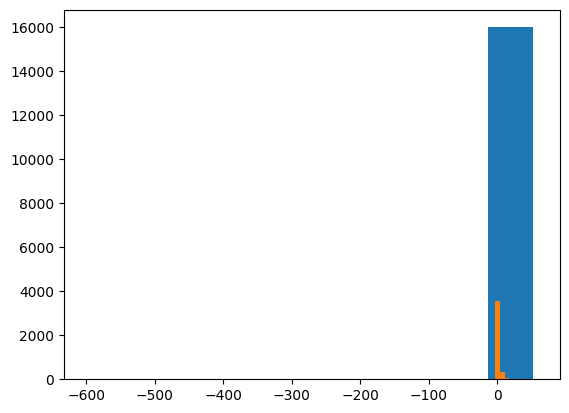

In [8]:
analyze_series(df_train.TargetPrice-df_train.BSAprox)
analyze_series(df_val.TargetPrice-df_val.BSAprox)

In [8]:
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_val) * np.sum((df_val.TargetPrice - df_val.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)

In [9]:
# import torch.multiprocessing as mp
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
    "Adam": torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    "Adamax": torch.optim.Adamax(
        model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99)
    ),
}
criteriation = nn.MSELoss()

In [10]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [11]:
train_loss_dict = {}
val_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, val_loss_dict)

Optimizer: SGD


100%|██████████| 32/32 [00:00<00:00, 237.25it/s]

Epoch 1, train loss: 304.6836, test loss: 286.7250



100%|██████████| 32/32 [00:00<00:00, 226.57it/s]

Epoch 2, train loss: 288.5409, test loss: 283.4601



100%|██████████| 32/32 [00:00<00:00, 225.29it/s]

Epoch 3, train loss: 286.7524, test loss: 283.4048



100%|██████████| 32/32 [00:00<00:00, 226.18it/s]

Epoch 4, train loss: 287.9323, test loss: 289.3815



100%|██████████| 32/32 [00:00<00:00, 269.76it/s]

Epoch 5, train loss: 287.4940, test loss: 285.9331



100%|██████████| 32/32 [00:00<00:00, 241.67it/s]

Epoch 6, train loss: 286.0753, test loss: 292.5740



100%|██████████| 32/32 [00:00<00:00, 255.41it/s]

Epoch 7, train loss: 285.7962, test loss: 283.5317



100%|██████████| 32/32 [00:00<00:00, 230.37it/s]

Epoch 8, train loss: 285.9711, test loss: 284.7431



100%|██████████| 32/32 [00:00<00:00, 286.72it/s]

Epoch 9, train loss: 285.0767, test loss: 284.6153



100%|██████████| 32/32 [00:00<00:00, 263.62it/s]

Epoch 10, train loss: 285.0443, test loss: 289.1842



100%|██████████| 32/32 [00:00<00:00, 239.69it/s]

Epoch 11, train loss: 285.7511, test loss: 284.8004



100%|██████████| 32/32 [00:00<00:00, 287.11it/s]

Epoch 12, train loss: 285.5661, test loss: 288.8553



100%|██████████| 32/32 [00:00<00:00, 262.29it/s]

Epoch 13, train loss: 284.9717, test loss: 284.9458



100%|██████████| 32/32 [00:00<00:00, 214.71it/s]

Epoch 14, train loss: 285.8169, test loss: 283.6167



100%|██████████| 32/32 [00:00<00:00, 298.24it/s]

Epoch 15, train loss: 285.9468, test loss: 287.6784



100%|██████████| 32/32 [00:00<00:00, 256.98it/s]

Epoch 16, train loss: 285.1991, test loss: 285.6489



100%|██████████| 32/32 [00:00<00:00, 293.62it/s]

Epoch 17, train loss: 285.2140, test loss: 283.3814



100%|██████████| 32/32 [00:00<00:00, 318.27it/s]

Epoch 18, train loss: 285.7539, test loss: 288.0351



100%|██████████| 125/125 [00:01<00:00, 124.94it/s]

Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 32/32 [00:00<00:00, 238.40it/s]

Epoch 19, train loss: 285.5372, test loss: 284.1706



100%|██████████| 32/32 [00:00<00:00, 203.54it/s]

Epoch 20, train loss: 283.6439, test loss: 283.6356
Optimizer: RMSprop



100%|██████████| 32/32 [00:00<00:00, 120.70it/s]

Epoch 1, train loss: 284.1373, test loss: 283.6914



100%|██████████| 32/32 [00:00<00:00, 242.09it/s]

Epoch 2, train loss: 283.6540, test loss: 283.5467



100%|██████████| 32/32 [00:00<00:00, 229.88it/s]

Epoch 3, train loss: 283.6053, test loss: 283.6650



100%|██████████| 32/32 [00:00<00:00, 243.14it/s]

Epoch 4, train loss: 283.5946, test loss: 283.6702



100%|██████████| 32/32 [00:00<00:00, 277.07it/s]

Epoch 5, train loss: 283.5021, test loss: 283.6135



100%|██████████| 32/32 [00:00<00:00, 265.61it/s]

Epoch 6, train loss: 283.5082, test loss: 283.6954



100%|██████████| 32/32 [00:00<00:00, 178.75it/s]

Epoch 7, train loss: 283.3486, test loss: 283.5262



100%|██████████| 32/32 [00:00<00:00, 246.92it/s]

Epoch 8, train loss: 283.2997, test loss: 283.8117



100%|██████████| 32/32 [00:00<00:00, 264.68it/s]

Epoch 9, train loss: 283.3008, test loss: 283.9017



100%|██████████| 32/32 [00:00<00:00, 219.88it/s]

Epoch 10, train loss: 283.2977, test loss: 284.2487



100%|██████████| 32/32 [00:00<00:00, 229.83it/s]

Epoch 11, train loss: 283.2314, test loss: 283.9382



100%|██████████| 32/32 [00:00<00:00, 291.17it/s]

Epoch 12, train loss: 283.1791, test loss: 284.1290



100%|██████████| 32/32 [00:00<00:00, 251.74it/s]

Epoch 13, train loss: 283.0514, test loss: 283.7737



100%|██████████| 32/32 [00:00<00:00, 245.54it/s]

Epoch 14, train loss: 282.9285, test loss: 284.1920



100%|██████████| 32/32 [00:00<00:00, 221.75it/s]

Epoch 15, train loss: 282.8937, test loss: 283.9786



100%|██████████| 32/32 [00:00<00:00, 296.50it/s]

Epoch 16, train loss: 282.8711, test loss: 283.7237



100%|██████████| 32/32 [00:00<00:00, 236.14it/s]

Epoch 17, train loss: 282.6686, test loss: 283.8752



100%|██████████| 32/32 [00:00<00:00, 267.22it/s]

Epoch 18, train loss: 282.5815, test loss: 285.3583



100%|██████████| 32/32 [00:00<00:00, 258.94it/s]

Epoch 19, train loss: 282.8172, test loss: 284.7269



100%|██████████| 32/32 [00:00<00:00, 303.50it/s]

Epoch 20, train loss: 282.5398, test loss: 283.9846
Optimizer: Adam



100%|██████████| 32/32 [00:00<00:00, 289.72it/s]

Epoch 1, train loss: 282.5794, test loss: 285.6324



100%|██████████| 32/32 [00:00<00:00, 260.67it/s]

Epoch 2, train loss: 282.1901, test loss: 285.4598



100%|██████████| 32/32 [00:00<00:00, 254.52it/s]

Epoch 3, train loss: 282.0587, test loss: 284.8295



100%|██████████| 32/32 [00:00<00:00, 272.03it/s]

Epoch 4, train loss: 282.5445, test loss: 283.9982



100%|██████████| 32/32 [00:00<00:00, 233.08it/s]

Epoch 5, train loss: 281.9707, test loss: 285.8232



100%|██████████| 32/32 [00:00<00:00, 261.98it/s]

Epoch 6, train loss: 282.1033, test loss: 284.8985



100%|██████████| 32/32 [00:00<00:00, 248.39it/s]

Epoch 7, train loss: 281.7740, test loss: 285.9245



100%|██████████| 32/32 [00:00<00:00, 230.86it/s]

Epoch 8, train loss: 282.7789, test loss: 285.3171



100%|██████████| 32/32 [00:00<00:00, 253.61it/s]

Epoch 9, train loss: 282.7347, test loss: 284.6777



100%|██████████| 32/32 [00:00<00:00, 255.05it/s]

Epoch 10, train loss: 282.4311, test loss: 285.1200



100%|██████████| 32/32 [00:00<00:00, 235.48it/s]

Epoch 11, train loss: 282.1730, test loss: 284.6204



100%|██████████| 32/32 [00:00<00:00, 267.16it/s]

Epoch 12, train loss: 282.0168, test loss: 284.9524



100%|██████████| 125/125 [00:00<00:00, 138.72it/s]

Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 32/32 [00:00<00:00, 286.16it/s]

Epoch 13, train loss: 281.8342, test loss: 287.2257



100%|██████████| 32/32 [00:00<00:00, 235.17it/s]

Epoch 14, train loss: 282.2136, test loss: 286.4869



100%|██████████| 32/32 [00:00<00:00, 273.67it/s]

Epoch 15, train loss: 281.6569, test loss: 286.1396



100%|██████████| 32/32 [00:00<00:00, 258.77it/s]

Epoch 16, train loss: 281.4156, test loss: 285.8698



100%|██████████| 32/32 [00:00<00:00, 228.07it/s]

Epoch 17, train loss: 281.2754, test loss: 285.7326



100%|██████████| 32/32 [00:00<00:00, 241.06it/s]

Epoch 18, train loss: 281.1604, test loss: 285.7227



100%|██████████| 32/32 [00:00<00:00, 292.85it/s]

Epoch 19, train loss: 281.0563, test loss: 285.6269



100%|██████████| 32/32 [00:00<00:00, 232.59it/s]

Epoch 20, train loss: 280.9947, test loss: 285.6351
Optimizer: Adamax



100%|██████████| 32/32 [00:00<00:00, 236.68it/s]

Epoch 1, train loss: 281.4722, test loss: 285.8812



100%|██████████| 32/32 [00:00<00:00, 238.30it/s]

Epoch 2, train loss: 280.9006, test loss: 285.6023



100%|██████████| 32/32 [00:00<00:00, 268.30it/s]

Epoch 3, train loss: 280.9083, test loss: 285.7679



100%|██████████| 32/32 [00:00<00:00, 247.67it/s]

Epoch 4, train loss: 280.7433, test loss: 285.6150



100%|██████████| 32/32 [00:00<00:00, 227.56it/s]

Epoch 5, train loss: 280.7724, test loss: 285.6657



100%|██████████| 32/32 [00:00<00:00, 226.51it/s]

Epoch 6, train loss: 280.5706, test loss: 285.5029



100%|██████████| 32/32 [00:00<00:00, 267.07it/s]

Epoch 7, train loss: 280.5112, test loss: 285.6937



100%|██████████| 32/32 [00:00<00:00, 268.60it/s]

Epoch 8, train loss: 280.4326, test loss: 285.9011



100%|██████████| 32/32 [00:00<00:00, 216.09it/s]

Epoch 9, train loss: 280.2780, test loss: 285.9722



100%|██████████| 32/32 [00:00<00:00, 260.63it/s]

Epoch 10, train loss: 280.2829, test loss: 285.5666



100%|██████████| 32/32 [00:00<00:00, 276.41it/s]

Epoch 11, train loss: 280.1143, test loss: 285.7396



100%|██████████| 32/32 [00:00<00:00, 297.58it/s]

Epoch 12, train loss: 280.0609, test loss: 285.5511



100%|██████████| 32/32 [00:00<00:00, 280.16it/s]

Epoch 13, train loss: 279.9694, test loss: 285.7143



100%|██████████| 32/32 [00:00<00:00, 247.05it/s]

Epoch 14, train loss: 279.8006, test loss: 286.2324



100%|██████████| 32/32 [00:00<00:00, 211.05it/s]

Epoch 15, train loss: 279.9848, test loss: 286.1821



100%|██████████| 32/32 [00:00<00:00, 268.37it/s]

Epoch 16, train loss: 279.7645, test loss: 285.8661



100%|██████████| 32/32 [00:00<00:00, 243.51it/s]

Epoch 17, train loss: 279.5792, test loss: 285.8770



100%|██████████| 32/32 [00:00<00:00, 239.21it/s]

Epoch 18, train loss: 279.7253, test loss: 286.3217



100%|██████████| 32/32 [00:00<00:00, 212.54it/s]

Epoch 19, train loss: 279.5948, test loss: 286.2000



100%|██████████| 32/32 [00:00<00:00, 222.55it/s]

Epoch 20, train loss: 279.6152, test loss: 286.1308


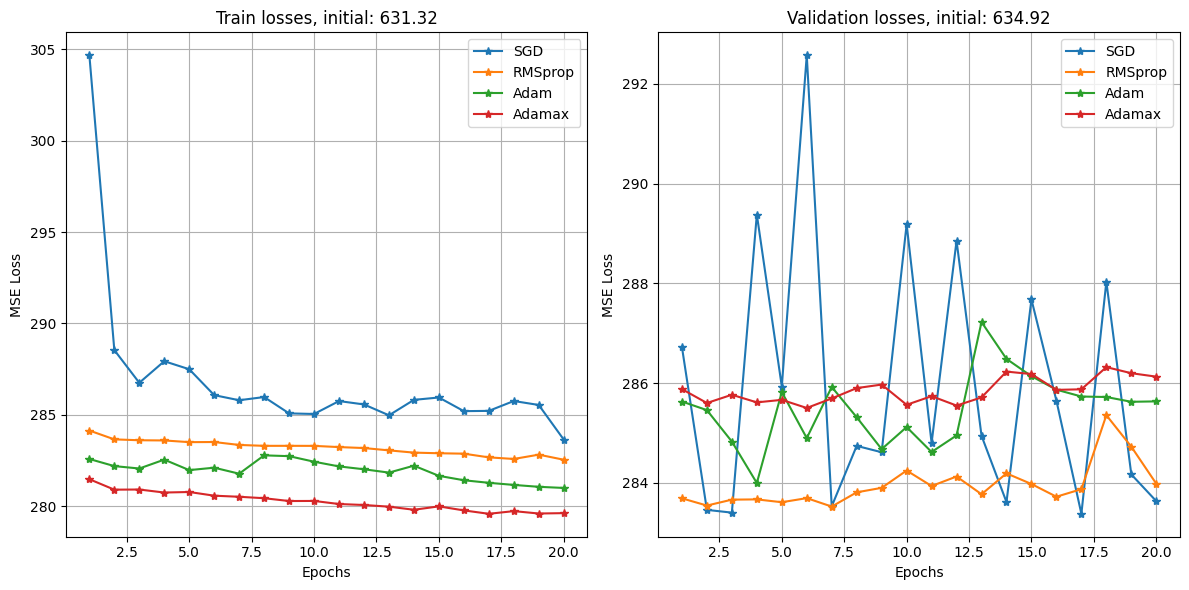

In [12]:
# Plot
plot_dictionaries(
    train_loss_dict,
    val_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_test.png",
)

### So for full training we will take Adam

In [13]:
# hyperparams for training
# df_real = pd.read_csv("../train_data/put_df_with_approx.csv", index_col=0)
N_EPOCH = 50
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 3e-5
HIDDEN_LAYER = 50
HIDDEN_WIDTH = 64
# EXPERIMENT_NAME = "exp_put_5_final"
# MODEL_TYPE = AmericanPut_gated3
# experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
# os.makedirs(experiment_dir, exist_ok=True)

In [14]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [15]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2)
logging.info(f"train set size: {df_train.shape}")
logging.info(f"test set size: {df_test.shape}")
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_test) * np.sum((df_test.TargetPrice - df_test.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)
train_df = CustomDataset(df_train)
test_df = CustomDataset(df_test)

In [17]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [18]:
# import torch.multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    test_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
}
criteriation = nn.MSELoss()

In [19]:
train_loss_dict = {}
test_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, test_loss_dict, final=True)

Optimizer: SGD


100%|██████████| 32/32 [00:00<00:00, 180.19it/s]

Epoch 1, train loss: 303.1424, test loss: 285.8064



100%|██████████| 32/32 [00:00<00:00, 146.59it/s]

Epoch 2, train loss: 286.8403, test loss: 286.9295



100%|██████████| 32/32 [00:00<00:00, 175.61it/s]


Epoch 3, train loss: 286.4151, test loss: 286.7275


100%|██████████| 32/32 [00:00<00:00, 185.32it/s]

Epoch 4, train loss: 285.3389, test loss: 288.1215



100%|██████████| 32/32 [00:00<00:00, 183.94it/s]

Epoch 5, train loss: 286.3150, test loss: 289.5272



100%|██████████| 32/32 [00:00<00:00, 194.24it/s]

Epoch 6, train loss: 286.1390, test loss: 287.5984



100%|██████████| 32/32 [00:00<00:00, 178.52it/s]

Epoch 7, train loss: 285.3677, test loss: 285.6588



100%|██████████| 32/32 [00:00<00:00, 177.97it/s]

Epoch 8, train loss: 285.4986, test loss: 286.2224



100%|██████████| 32/32 [00:00<00:00, 182.13it/s]

Epoch 9, train loss: 284.7772, test loss: 286.3584



100%|██████████| 32/32 [00:00<00:00, 147.48it/s]

Epoch 10, train loss: 284.6351, test loss: 286.6463



100%|██████████| 32/32 [00:00<00:00, 163.08it/s]


Epoch 11, train loss: 284.9247, test loss: 285.3106


100%|██████████| 32/32 [00:00<00:00, 178.22it/s]

Epoch 12, train loss: 283.7651, test loss: 285.5799



100%|██████████| 32/32 [00:00<00:00, 163.90it/s]


Epoch 13, train loss: 284.6522, test loss: 288.9658


100%|██████████| 32/32 [00:00<00:00, 171.79it/s]


Epoch 14, train loss: 284.0440, test loss: 286.3788


100%|██████████| 32/32 [00:00<00:00, 164.54it/s]


Epoch 15, train loss: 284.2627, test loss: 285.9659


100%|██████████| 32/32 [00:00<00:00, 195.25it/s]

Epoch 16, train loss: 283.5112, test loss: 286.1225



100%|██████████| 32/32 [00:00<00:00, 177.41it/s]

Epoch 17, train loss: 283.1402, test loss: 289.6647



100%|██████████| 32/32 [00:00<00:00, 179.97it/s]

Epoch 18, train loss: 283.4547, test loss: 286.3224



100%|██████████| 32/32 [00:00<00:00, 195.32it/s]

Epoch 19, train loss: 283.5581, test loss: 285.8836



100%|██████████| 32/32 [00:00<00:00, 180.32it/s]

Epoch 20, train loss: 283.5605, test loss: 286.5777



100%|██████████| 32/32 [00:00<00:00, 159.38it/s]

Epoch 21, train loss: 283.6515, test loss: 286.7986



100%|██████████| 32/32 [00:00<00:00, 172.95it/s]

Epoch 22, train loss: 283.2308, test loss: 287.3180



100%|██████████| 125/125 [00:01<00:00, 82.30it/s]

Epoch 00023: reducing learning rate of group 0 to 3.0000e-06.



100%|██████████| 32/32 [00:00<00:00, 169.88it/s]


Epoch 23, train loss: 283.1683, test loss: 285.9913


100%|██████████| 32/32 [00:00<00:00, 140.53it/s]

Epoch 24, train loss: 280.8453, test loss: 285.9342



100%|██████████| 32/32 [00:00<00:00, 174.91it/s]

Epoch 25, train loss: 280.4270, test loss: 285.9458



100%|██████████| 32/32 [00:00<00:00, 179.09it/s]

Epoch 26, train loss: 280.3189, test loss: 286.1101



100%|██████████| 32/32 [00:00<00:00, 174.13it/s]


Epoch 27, train loss: 280.2916, test loss: 286.3226


100%|██████████| 32/32 [00:00<00:00, 186.69it/s]

Epoch 28, train loss: 280.1291, test loss: 286.2792



100%|██████████| 32/32 [00:00<00:00, 181.21it/s]

Epoch 29, train loss: 280.0466, test loss: 286.5631



100%|██████████| 32/32 [00:00<00:00, 189.39it/s]

Epoch 30, train loss: 280.0297, test loss: 286.4317



100%|██████████| 32/32 [00:00<00:00, 149.87it/s]

Epoch 31, train loss: 279.8768, test loss: 286.3557



100%|██████████| 32/32 [00:00<00:00, 175.04it/s]

Epoch 32, train loss: 279.8059, test loss: 286.9968



100%|██████████| 32/32 [00:00<00:00, 172.64it/s]

Epoch 33, train loss: 279.8268, test loss: 286.5754



100%|██████████| 32/32 [00:00<00:00, 186.34it/s]

Epoch 34, train loss: 279.6562, test loss: 286.5879



100%|██████████| 32/32 [00:00<00:00, 163.41it/s]


Epoch 35, train loss: 279.4935, test loss: 286.8185


100%|██████████| 32/32 [00:00<00:00, 170.37it/s]


Epoch 36, train loss: 279.5469, test loss: 286.7903


100%|██████████| 32/32 [00:00<00:00, 171.62it/s]


Epoch 37, train loss: 279.5107, test loss: 286.7298


100%|██████████| 32/32 [00:00<00:00, 179.58it/s]

Epoch 38, train loss: 279.3903, test loss: 286.7177



100%|██████████| 32/32 [00:00<00:00, 181.52it/s]

Epoch 39, train loss: 279.2893, test loss: 286.8274



100%|██████████| 32/32 [00:00<00:00, 185.21it/s]

Epoch 40, train loss: 279.0354, test loss: 286.8369



100%|██████████| 32/32 [00:00<00:00, 158.91it/s]

Epoch 41, train loss: 279.1777, test loss: 286.8214



100%|██████████| 32/32 [00:00<00:00, 206.19it/s]

Epoch 42, train loss: 279.2067, test loss: 286.8143



100%|██████████| 32/32 [00:00<00:00, 188.47it/s]

Epoch 43, train loss: 279.0419, test loss: 287.0307



100%|██████████| 32/32 [00:00<00:00, 169.36it/s]


Epoch 44, train loss: 278.8812, test loss: 287.3334


100%|██████████| 32/32 [00:00<00:00, 178.10it/s]

Epoch 45, train loss: 278.7806, test loss: 287.3109



100%|██████████| 32/32 [00:00<00:00, 165.88it/s]


Epoch 46, train loss: 278.7041, test loss: 287.6727


100%|██████████| 32/32 [00:00<00:00, 183.60it/s]

Epoch 47, train loss: 278.6914, test loss: 287.1617



100%|██████████| 32/32 [00:00<00:00, 181.01it/s]

Epoch 48, train loss: 278.4421, test loss: 286.8702



100%|██████████| 32/32 [00:00<00:00, 187.94it/s]

Epoch 49, train loss: 278.4277, test loss: 287.3783



100%|██████████| 32/32 [00:00<00:00, 157.03it/s]

Epoch 50, train loss: 278.2038, test loss: 287.3902


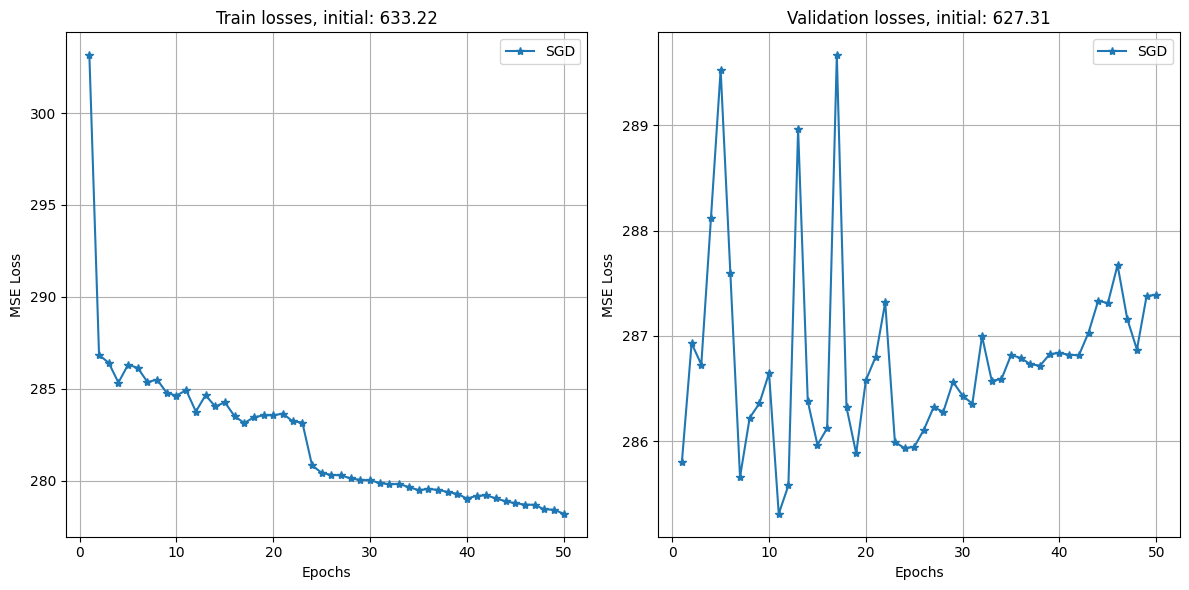

In [20]:
plot_dictionaries(
    train_loss_dict,
    test_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [21]:
import json

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "w") as json_file:
    json.dump(train_loss_dict, json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "w") as json_file:
    json.dump(test_loss_dict, json_file)

In [24]:
logging.info(
    f"% of variation before training: {(initial_mse_train/(df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(train_loss_dict['SGD'][11]/ (df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation before training: {(initial_mse_val/(df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(test_loss_dict['SGD'][11] / (df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)

In [29]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH, 100):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [30]:
train_loss_dict = {}
test_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, test_loss_dict, final=True)

Optimizer: Adam


100%|██████████| 698/698 [00:02<00:00, 346.55it/s]

Epoch 51, train loss: 15.1520, test loss: 15.0572



100%|██████████| 698/698 [00:02<00:00, 321.40it/s]

Epoch 52, train loss: 15.3887, test loss: 14.7960



100%|██████████| 698/698 [00:01<00:00, 350.77it/s]

Epoch 53, train loss: 15.1600, test loss: 15.0739



100%|██████████| 698/698 [00:01<00:00, 362.00it/s]

Epoch 54, train loss: 15.5402, test loss: 14.8740



100%|██████████| 698/698 [00:01<00:00, 357.46it/s]

Epoch 55, train loss: 15.3245, test loss: 14.9195



100%|██████████| 698/698 [00:01<00:00, 368.30it/s]

Epoch 56, train loss: 14.5784, test loss: 15.5519



100%|██████████| 698/698 [00:01<00:00, 362.18it/s]

Epoch 57, train loss: 14.6905, test loss: 15.2107



100%|██████████| 698/698 [00:01<00:00, 363.73it/s]

Epoch 58, train loss: 14.7698, test loss: 15.0287



100%|██████████| 698/698 [00:01<00:00, 366.32it/s]

Epoch 59, train loss: 14.6966, test loss: 14.9380



100%|██████████| 698/698 [00:01<00:00, 360.32it/s]

Epoch 60, train loss: 14.7310, test loss: 14.8965



100%|██████████| 698/698 [00:01<00:00, 367.51it/s]

Epoch 61, train loss: 15.1140, test loss: 14.9883



100%|██████████| 2791/2791 [00:20<00:00, 133.78it/s]

Epoch 00012: reducing learning rate of group 0 to 3.0000e-06.



100%|██████████| 698/698 [00:02<00:00, 348.21it/s]

Epoch 62, train loss: 15.0032, test loss: 15.0009



100%|██████████| 698/698 [00:02<00:00, 333.69it/s]


Epoch 63, train loss: 13.9765, test loss: 14.9068


100%|██████████| 698/698 [00:01<00:00, 383.90it/s]

Epoch 64, train loss: 13.9467, test loss: 14.8981



100%|██████████| 698/698 [00:01<00:00, 386.41it/s]

Epoch 65, train loss: 13.9420, test loss: 14.8892



100%|██████████| 698/698 [00:01<00:00, 385.55it/s]

Epoch 66, train loss: 13.9126, test loss: 14.8817



100%|██████████| 698/698 [00:01<00:00, 383.74it/s]

Epoch 67, train loss: 13.9087, test loss: 14.8849



100%|██████████| 698/698 [00:01<00:00, 386.19it/s]

Epoch 68, train loss: 13.8657, test loss: 14.8844



100%|██████████| 698/698 [00:01<00:00, 381.88it/s]

Epoch 69, train loss: 13.8717, test loss: 14.8792



100%|██████████| 698/698 [00:01<00:00, 382.20it/s]

Epoch 70, train loss: 13.8497, test loss: 14.8795



100%|██████████| 698/698 [00:01<00:00, 376.96it/s]


Epoch 71, train loss: 13.8242, test loss: 14.8854


100%|██████████| 698/698 [00:01<00:00, 352.94it/s]

Epoch 72, train loss: 13.8136, test loss: 14.9072



100%|██████████| 698/698 [00:02<00:00, 341.90it/s]

Epoch 73, train loss: 13.8525, test loss: 14.8810



100%|██████████| 698/698 [00:02<00:00, 342.65it/s]

Epoch 74, train loss: 13.7920, test loss: 14.8710



100%|██████████| 698/698 [00:01<00:00, 356.31it/s]

Epoch 75, train loss: 13.8038, test loss: 14.8800



100%|██████████| 698/698 [00:01<00:00, 395.53it/s]

Epoch 76, train loss: 13.7929, test loss: 14.8801



100%|██████████| 698/698 [00:01<00:00, 409.48it/s]

Epoch 77, train loss: 13.7795, test loss: 14.8827



100%|██████████| 698/698 [00:01<00:00, 355.67it/s]

Epoch 78, train loss: 13.7519, test loss: 14.9581



100%|██████████| 698/698 [00:01<00:00, 358.27it/s]

Epoch 79, train loss: 13.7587, test loss: 14.8782



100%|██████████| 698/698 [00:02<00:00, 341.55it/s]

Epoch 80, train loss: 13.7785, test loss: 14.9013



100%|██████████| 698/698 [00:01<00:00, 353.28it/s]

Epoch 81, train loss: 13.7422, test loss: 14.8886



100%|██████████| 698/698 [00:01<00:00, 397.55it/s]

Epoch 82, train loss: 13.7631, test loss: 14.8928



100%|██████████| 698/698 [00:02<00:00, 336.77it/s]

Epoch 83, train loss: 13.7549, test loss: 14.8892



100%|██████████| 698/698 [00:01<00:00, 367.69it/s]

Epoch 84, train loss: 13.7512, test loss: 14.8932



100%|██████████| 698/698 [00:01<00:00, 352.76it/s]

Epoch 85, train loss: 13.7179, test loss: 14.8955



100%|██████████| 698/698 [00:01<00:00, 364.66it/s]

Epoch 86, train loss: 13.7321, test loss: 14.9013



100%|██████████| 698/698 [00:01<00:00, 359.67it/s]


Epoch 87, train loss: 13.7366, test loss: 14.8958


100%|██████████| 698/698 [00:01<00:00, 363.28it/s]

Epoch 88, train loss: 13.6819, test loss: 14.9143



100%|██████████| 698/698 [00:01<00:00, 379.32it/s]

Epoch 89, train loss: 13.6712, test loss: 14.9184



100%|██████████| 698/698 [00:01<00:00, 400.47it/s]

Epoch 90, train loss: 13.7265, test loss: 14.9111



100%|██████████| 698/698 [00:01<00:00, 424.63it/s]

Epoch 91, train loss: 13.6992, test loss: 14.9058



100%|██████████| 698/698 [00:01<00:00, 376.12it/s]

Epoch 92, train loss: 13.7273, test loss: 14.9105



100%|██████████| 698/698 [00:01<00:00, 371.47it/s]

Epoch 93, train loss: 13.6984, test loss: 14.9097



100%|██████████| 698/698 [00:01<00:00, 377.15it/s]


Epoch 94, train loss: 13.6989, test loss: 14.9163


100%|██████████| 2791/2791 [00:20<00:00, 137.37it/s]

Epoch 00045: reducing learning rate of group 0 to 3.0000e-07.



100%|██████████| 698/698 [00:01<00:00, 349.47it/s]

Epoch 95, train loss: 13.7266, test loss: 14.9154



100%|██████████| 698/698 [00:01<00:00, 353.70it/s]

Epoch 96, train loss: 13.5943, test loss: 14.9160



100%|██████████| 698/698 [00:01<00:00, 388.76it/s]

Epoch 97, train loss: 13.5934, test loss: 14.9140



100%|██████████| 698/698 [00:01<00:00, 378.01it/s]

Epoch 98, train loss: 13.5931, test loss: 14.9152



100%|██████████| 698/698 [00:01<00:00, 369.65it/s]

Epoch 99, train loss: 13.5932, test loss: 14.9155



100%|██████████| 698/698 [00:01<00:00, 377.52it/s]

Epoch 100, train loss: 13.5906, test loss: 14.9126


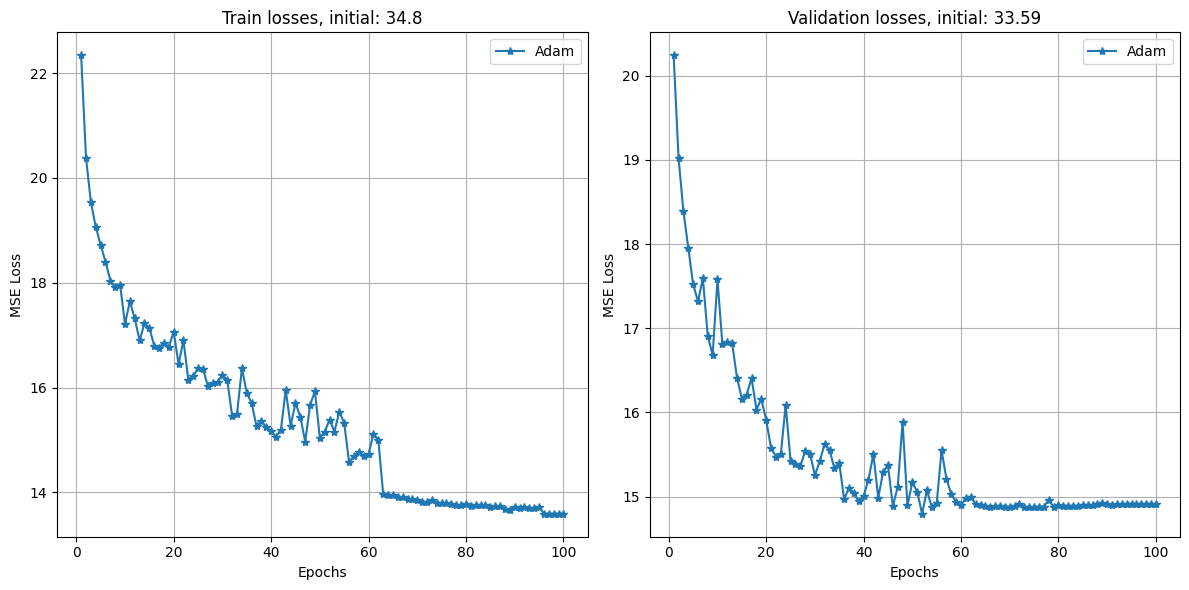

In [45]:
file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "r") as json_file:
    first_50_train = json.load(json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "r") as json_file:
    first_50_test = json.load(json_file)

train = np.concatenate((first_50_train["Adam"], train_loss_dict["Adam"]))
test = np.concatenate((first_50_test["Adam"], test_loss_dict["Adam"]))
train_all = {"Adam":train}
test_all = {"Adam":test}
plot_dictionaries(
    train_all,
    test_all,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [49]:
print(
    f"% of variation before training: {(initial_mse_train*100/(df_train.TargetPrice - df_train.BSAprox).var()).round(2)}"
)
print(
    f"% of variation after training: {(train_all['Adam'][60]*100/ (df_train.TargetPrice - df_train.BSAprox).var()).round(2)}"
)
print(
    f"% of variation before training: {(initial_mse_val*100/(df_test.TargetPrice - df_test.BSAprox).var()).round(2)}"
)
print(
    f"% of variation after training: {(train_all['Adam'][60]*100 / (df_test.TargetPrice - df_test.BSAprox).var()).round(2)}"
)

% of variation before training: 108.54
% of variation after training: 47.15
% of variation before training: 108.57
% of variation after training: 48.85
